In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
! curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [9]:
! git clone https://github.com/ryuntp/floodDetection.git

Cloning into 'floodDetection'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 172 (delta 8), reused 148 (delta 1), pack-reused 0
Receiving objects: 100% (172/172), 39.91 MiB | 10.44 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [0]:
path = Path('floodDetection')

In [0]:
path_labels = path/"labels"
path_images = path/'images'

In [12]:
filenames = get_image_files(path_images)
filenames[:10]

[PosixPath('floodDetection/images/Label_52.png'),
 PosixPath('floodDetection/images/Label_45.png'),
 PosixPath('floodDetection/images/Label_58.png'),
 PosixPath('floodDetection/images/Label_47.png'),
 PosixPath('floodDetection/images/Label_37.png'),
 PosixPath('floodDetection/images/Label_65.png'),
 PosixPath('floodDetection/images/Label_36.png'),
 PosixPath('floodDetection/images/Label_26.png'),
 PosixPath('floodDetection/images/Label_9.png'),
 PosixPath('floodDetection/images/Label_6.png')]

In [13]:
label_names = get_image_files(path_labels)
label_names[:10]

[PosixPath('floodDetection/labels/Label_6_P.png'),
 PosixPath('floodDetection/labels/Label_14_P.png'),
 PosixPath('floodDetection/labels/Label_19_P.png'),
 PosixPath('floodDetection/labels/Label_58_P.png'),
 PosixPath('floodDetection/labels/Label_33_P.png'),
 PosixPath('floodDetection/labels/Label_48_P.png'),
 PosixPath('floodDetection/labels/Label_30_P.png'),
 PosixPath('floodDetection/labels/Label_26_P.png'),
 PosixPath('floodDetection/labels/Label_44_P.png'),
 PosixPath('floodDetection/labels/Label_4_P.png')]

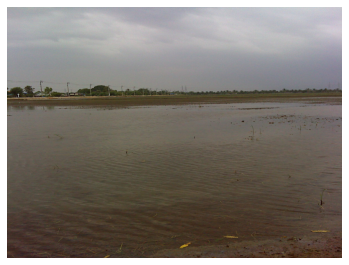

In [14]:
image_file = filenames[7]
image = open_image(image_file)
image.show(figsize=(6,6))

In [0]:
get_y_fn = lambda x: path_labels/f'{x.stem}_P{x.suffix}'

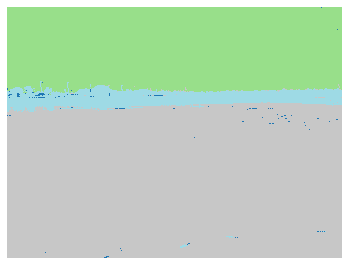

In [16]:
mask = open_mask(get_y_fn(image_file))
mask.show(figsize=(6,6), alpha=1)

In [17]:
source_size = np.array(mask.shape[1:])
source_size, mask.data

(array([720, 960]), tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

In [18]:
codes = np.loadtxt(path/'code.txt', dtype=str)
len(codes), codes

(5, array(['Void', 'sky', 'rice', 'water', 'backg'], dtype='<U5'))

In [19]:
size = source_size//2
bs = 0

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 16000: bs=16    
elif free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 16270MB of GPU RAM free


In [0]:
segmentitemlist = (SegmentationItemList.from_folder(path_images)
              .split_by_rand_pct(valid_pct=0.2)
              .label_from_func(get_y_fn, classes=codes))
# print(segmentitemlist)

In [0]:
databunch = (segmentitemlist.transform(get_transforms(), 
                                  size=size, tfm_y=True)
             .databunch(bs=bs)
             .normalize(imagenet_stats))

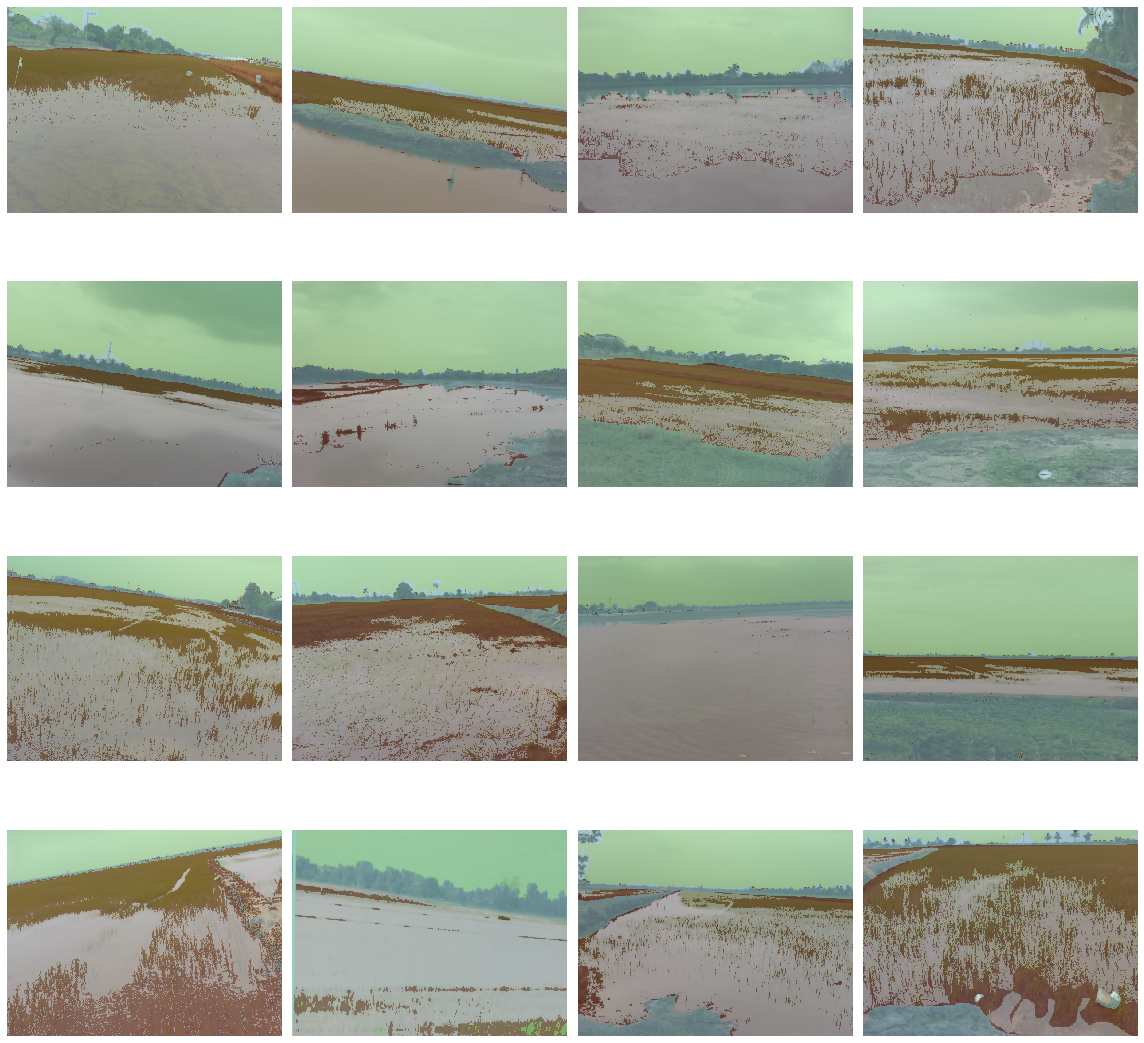

In [22]:
databunch.show_batch()

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [0]:
learner = unet_learner(databunch, models.resnet34, 
                       metrics=metrics, wd=wd, 
                       callback_fns=ShowGraph).to_fp16()

In [0]:
lr=3e-3

epoch,train_loss,valid_loss,acc_camvid,time
0,3.375296,1.642305,0.222300,00:29
1,2.425364,1.222008,0.564196,00:05
2,1.961188,1.263320,0.424154,00:05
3,1.712203,1.092139,0.532615,00:05
4,1.542261,0.853498,0.699876,00:05
5,1.407431,0.851184,0.575785,00:05
6,1.299553,0.798220,0.639297,00:05
7,1.208625,0.692686,0.684140,00:05
8,1.112630,0.686812,0.746399,00:05
9,1.043931,0.658301,0.748019,00:05


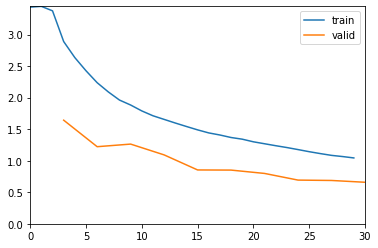

In [36]:
learner.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [0]:
learner.save('unet-resnet34-1')

In [0]:
learner.load('unet-resnet34-1');

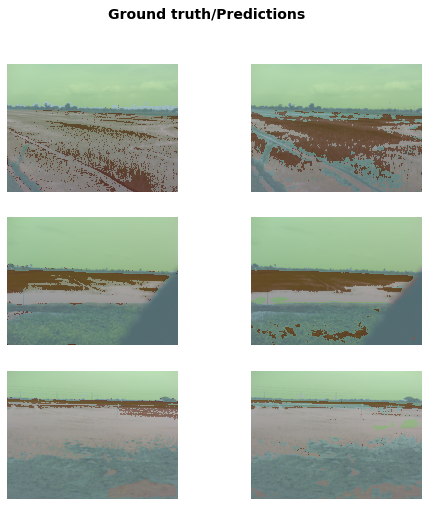

In [39]:
learner.show_results(rows=3, figsize=(8, 8))

In [0]:
learner.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.573395,0.586587,0.777563,00:06
1,0.520242,0.530510,0.792922,00:06
2,0.501713,0.582411,0.777816,00:06
3,0.484799,0.528103,0.799159,00:05
4,0.470261,0.520155,0.798707,00:06
5,0.460909,0.483275,0.806933,00:06
6,0.448565,0.564172,0.745863,00:06
7,0.446314,0.492683,0.799830,00:06
8,0.436869,0.438944,0.828889,00:06
9,0.432360,0.559891,0.803251,00:06


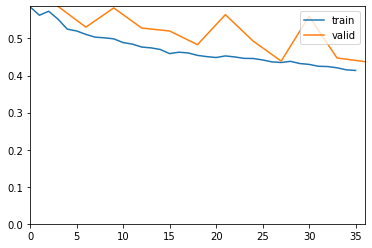

In [42]:
learner.fit_one_cycle(12, lrs, pct_start=0.8)

In [0]:
learner.save('unet-resnet34-2')

In [0]:
learner.load('unet-resnet34-2');

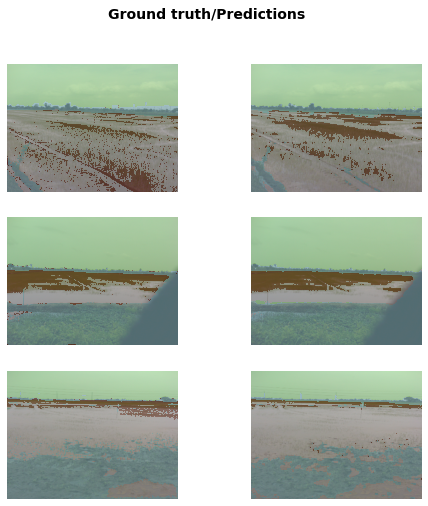

In [45]:
learner.show_results(rows=3, figsize=(8, 8))